### Model Aggregation Scheme Overview

##### Summary
Trained 6 models [FedAvg, FAT] x [Vanilla, Trimmed Mean, Median]. Record test acc and adv acc for each setting. Each model has only been trained for 50 round to save time.

Table 2 

In [1]:
cd /home/ubuntu/fedatk_unl_tj

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
setting, num_user = "FedAvg", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
# Change path to where models are stored trained via trimmed mean and median given noniid induced by FAT 
# model is trained by run_model_training/train_model_noniid_sweep.py
save_path_tm_iid = "/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/tm_iid/"
save_path_tm_niid = "/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/tm_niid/"
save_path_med_iid = "/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/med_iid/"
save_path_med_niid = "/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/med_niid/"

model_tm_iid = copy.deepcopy(import_model_weights(num_user, setting, save_path_tm_iid, aggregator, args_)[0])
model_tm_niid = copy.deepcopy(import_model_weights(num_user, setting, save_path_tm_niid, aggregator, args_)[0])

model_med_iid = copy.deepcopy(import_model_weights(num_user, setting, save_path_med_iid, aggregator, args_)[0])
model_med_niid = copy.deepcopy(import_model_weights(num_user, setting, save_path_med_niid, aggregator, args_)[0])

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 120.90it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:05<00:00,  6.69it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [4]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
            'adv_similarities_untarget','adv_target','adv_miss']

# Perform transfer attack from one client to another and record stats
models_test = [model_tm_iid, model_tm_niid,model_med_iid,model_med_niid]

# Run Measurements for both targetted and untargeted analysis
victim_idxs = range(len(models_test))
custom_batch_size = 1000
eps = 4.0

num_cid = 5
c_id_list = range(num_cid)

acc_store = np.zeros([num_cid, len(models_test)])
adv_store = np.zeros([num_cid, len(models_test)])


for t in c_id_list:
    print("Running cid trial", t)
    logs_adv = generate_logs_adv(len(models_test))
    dataloader = load_client_data(clients = clients, c_id = t, mode = 'test') # or test/train
    cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)
    
    adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
    acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)
    adv_target = get_metric_list("adv_target", logs_adv, victim_idxs)
    
    for m in range(len(models_test)):
        acc_store[t,m] = acc[m,m]
        adv_store[t,m] = adv_miss[m,m]




Running cid trial 0
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
Running cid trial 1
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
Running cid trial 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
Running cid trial 3
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
Running cid trial 4
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3


In [5]:
adv_store

array([[0.47, 0.35, 0.57, 0.34],
       [0.41, 0.28, 0.52, 0.31],
       [0.48, 0.29, 0.54, 0.37],
       [0.35, 0.28, 0.48, 0.31],
       [0.40, 0.23, 0.48, 0.25]])

In [6]:
# Print along diagonal and plot "robustness against white-box attacks (self)"
adv_list = []
acc_list = []
adv_std_list = []
acc_std_list = []
for i in range(len(models_test)):
    adv_list += [np.mean(adv_store[:,i])]
    acc_list += [np.mean(acc_store[:,i])]
    
    adv_std_list += [np.std(adv_store[:,i])]
    acc_std_list += [np.std(acc_store[:,i])]



In [9]:
from prettytable import PrettyTable

# Your lists
labels = ['TM_iid', 'TM_niid', 'Med_iid', 'Med_niid']
x_values = acc_list
y_values = adv_list
xstd_values = acc_std_list
ystd_values = adv_std_list

# Creating the table
table = PrettyTable()
table.field_names = ["Setting", "Test Acc", "Test Acc STD", "Adv Acc", "Adv Acc STD"]

# Adding rows
for label, x, x1, y, y1 in zip(labels, x_values, xstd_values, y_values,ystd_values):
    table.add_row([label, x, x1, y, y1])

# Printing the table
print(table)


+----------+--------------------+----------------------+---------------------+---------------------+
| Setting  |      Test Acc      |     Test Acc STD     |       Adv Acc       |     Adv Acc STD     |
+----------+--------------------+----------------------+---------------------+---------------------+
|  TM_iid  | 0.8172259449958801 | 0.03096604724400304  | 0.42284799814224244 | 0.04946804434469969 |
| TM_niid  | 0.8172710299491882 | 0.030829598283105025 |  0.2848703145980835 | 0.03768478208152037 |
| Med_iid  | 0.8031113862991333 | 0.022935331031556924 |  0.5181314527988434 | 0.03665270265445393 |
| Med_niid | 0.8062481760978699 | 0.007653997879287788 |  0.3166157782077789 | 0.03799640415606277 |
+----------+--------------------+----------------------+---------------------+---------------------+


In [10]:
adv_miss

array([[0.40, 0.58, 0.54, 0.52],
       [0.62, 0.23, 0.54, 0.47],
       [0.66, 0.66, 0.48, 0.59],
       [0.76, 0.60, 0.64, 0.25]])

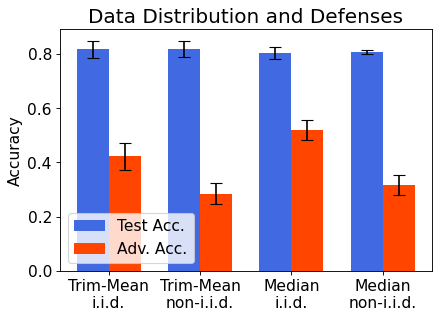

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Use existing variables
settings = ['Trim-Mean\ni.i.d.', 'Trim-Mean\nnon-i.i.d.', 'Median\ni.i.d.', 'Median\nnon-i.i.d.']
test_acc = x_values  # acc_list
test_acc_std = xstd_values  # acc_std_list
adv_acc = y_values  # adv_list
adv_acc_std = ystd_values  # adv_std_list

# Bar width and positions
bar_width = 0.35
x = np.arange(len(settings))

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
bars1 = ax.bar(x - bar_width/2, test_acc, bar_width, yerr=test_acc_std, capsize=5, label="Test Acc.", color="royalblue")
bars2 = ax.bar(x + bar_width/2, adv_acc, bar_width, yerr=adv_acc_std, capsize=5, label="Adv. Acc.", color="orangered")

# Labels and titles
ax.set_ylabel("Accuracy", size = 14)
ax.set_title("Data Distribution and Defenses", size = 18)
ax.set_xticks(x)
ax.set_xticklabels(settings, size = 14)
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis label size
ax.legend(fontsize = 14)

# Display the plot
plt.show()
